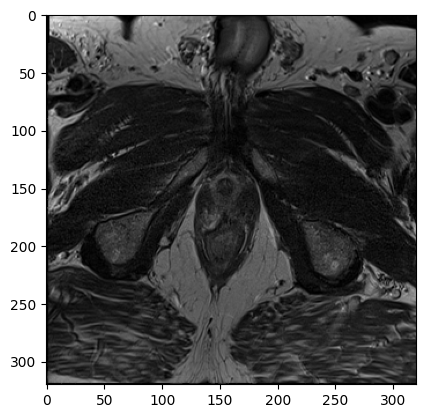

In [13]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Percorso del file .mhd
mhd_file_path = 'test_data/Case04.mhd'

# Carica l'immagine
image = sitk.ReadImage(mhd_file_path)

# Converte l'immagine in un array NumPy (per visualizzarla)
image_array = sitk.GetArrayFromImage(image)

# Visualizza la prima slice (se è un'immagine 3D)
plt.imshow(image_array[0], cmap='gray')
plt.show()


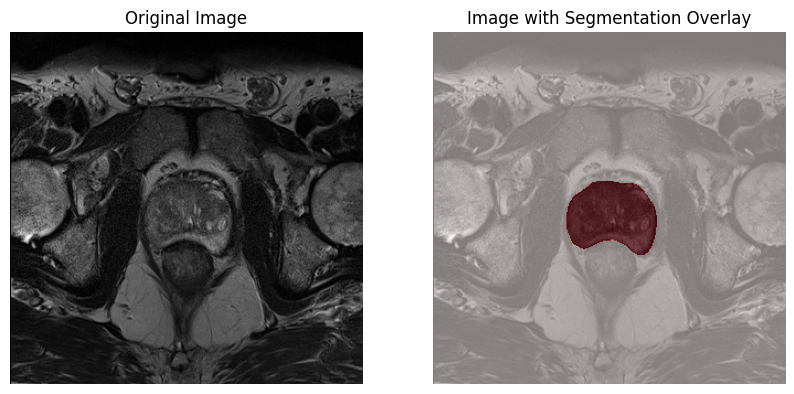

In [26]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_with_segmentation(image_path, segmentation_path, slice_index=0):
    # Load the image and segmentation
    image = sitk.ReadImage(image_path)
    segmentation = sitk.ReadImage(segmentation_path)

    # Convert to NumPy arrays
    image_array = sitk.GetArrayFromImage(image)
    segmentation_array = sitk.GetArrayFromImage(segmentation)

    # Extract the slice
    image_slice = image_array[slice_index]
    segmentation_slice = segmentation_array[slice_index]

    # Overlay visualization
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_slice, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Segmentation overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image_slice, cmap='gray')
    plt.imshow(segmentation_slice, alpha=0.5, cmap='Reds')  # Overlay in red
    plt.title("Image with Segmentation Overlay")
    plt.axis('off')

    plt.show()

# Example usage
visualize_image_with_segmentation("test_data/Case00.mhd", "test_data/Case00_segmentation.mhd", slice_index=5)


Nessun segmento trovato nella slice 0 di Case21.mhd.
Nessun segmento trovato nella slice 1 di Case21.mhd.
Nessun segmento trovato nella slice 2 di Case21.mhd.
Nessun segmento trovato nella slice 3 di Case21.mhd.
File: Case21.mhd, Slice: 4, IoU: 0.0155
File: Case21.mhd, Slice: 5, IoU: 0.0233
File: Case21.mhd, Slice: 6, IoU: 0.0391
File: Case21.mhd, Slice: 7, IoU: 0.0517
File: Case21.mhd, Slice: 8, IoU: 0.0716
File: Case21.mhd, Slice: 9, IoU: 0.0766
File: Case21.mhd, Slice: 10, IoU: 0.0724
File: Case21.mhd, Slice: 11, IoU: 0.0840
File: Case21.mhd, Slice: 12, IoU: 0.0912
File: Case21.mhd, Slice: 13, IoU: 0.0780
File: Case21.mhd, Slice: 14, IoU: 0.0749
File: Case21.mhd, Slice: 15, IoU: 0.0471
Nessun segmento trovato nella slice 16 di Case21.mhd.
Nessun segmento trovato nella slice 17 di Case21.mhd.
Nessun segmento trovato nella slice 18 di Case21.mhd.
Nessun segmento trovato nella slice 19 di Case21.mhd.
Nessun segmento trovato nella slice 20 di Case21.mhd.
Nessun segmento trovato nella sl

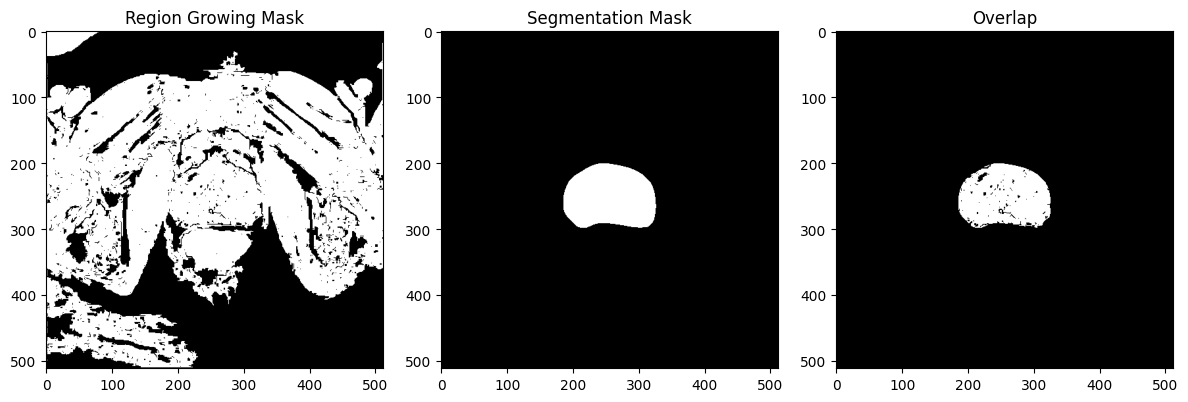

In [37]:
import SimpleITK as sitk
import numpy as np
import os
from collections import deque
from numba import njit
import matplotlib.pyplot as plt


# Funzione Region Growing (Top-Down)
@njit
def top_down_region_growing(image, seed, threshold):
    rows, cols = image.shape
    mask = np.zeros((rows, cols), dtype=np.bool_)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # 4-connectivity

    # Usa una lista invece di deque
    queue = [seed]
    mask[seed] = True

    # Perform region growing
    while len(queue) > 0:
        x, y = queue.pop(0)  # Estrai il primo elemento
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and not mask[nx, ny]:
                if abs(int(image[nx, ny]) - int(image[x, y])) <= threshold:
                    mask[nx, ny] = True
                    queue.append((nx, ny))  # Aggiungi alla coda
    return mask


# Funzione per calcolare l'overlap
def calculate_overlap(region_mask, segmentation_mask):
    """
    Calcola la sovrapposizione (intersection over union) tra la maschera trovata e quella di segmentazione.

    Args:
        region_mask (np.ndarray): Maschera calcolata dall'algoritmo di Region Growing.
        segmentation_mask (np.ndarray): Maschera fornita nel file di segmentazione.

    Returns:
        float: IoU (Intersection over Union).
    """
    intersection = np.logical_and(region_mask, segmentation_mask).sum()
    union = np.logical_or(region_mask, segmentation_mask).sum()
    return intersection / union if union > 0 else 0.0


# Funzione principale
def process_images(folder_path, threshold=15):
    """
    Applica Region Growing a tutte le immagini nella cartella e confronta le maschere calcolate con quelle di segmentazione.

    Args:
        folder_path (str): Path alla cartella contenente i file .mhd.
        threshold (int): Soglia di similarità per il Region Growing.

    Returns:
        list of dict: Risultati per ogni immagine, contenenti IoU e maschere.
    """
    results = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mhd") and not "_segmentation" in file_name:
            base_name = file_name.replace(".mhd", "")
            
            # Percorsi dei file immagine e segmentazione
            image_file = os.path.join(folder_path, f"{base_name}.mhd")
            segmentation_file = os.path.join(folder_path, f"{base_name}_segmentation.mhd")
            
            if not os.path.exists(segmentation_file):
                print(f"Segmentazione non trovata per {file_name}, saltato.")
                continue
            
            # Carica immagine e segmentazione
            image = sitk.ReadImage(image_file)
            segmentation = sitk.ReadImage(segmentation_file)
            image_array = sitk.GetArrayFromImage(image)
            segmentation_array = sitk.GetArrayFromImage(segmentation)
            
            # Lavora su ciascuna slice
            for slice_index in range(image_array.shape[0]):
                image_slice = image_array[slice_index]
                segmentation_slice = segmentation_array[slice_index] > 0  # Crea maschera binaria
                
                # Trova il centro del segmento
                coords = np.argwhere(segmentation_slice)
                if len(coords) == 0:
                    print(f"Nessun segmento trovato nella slice {slice_index} di {file_name}.")
                    continue
                center = tuple(coords[len(coords) // 2])  # Centroide approssimato
                
                # Applica Region Growing
                region_mask = top_down_region_growing(image_slice, center, threshold)
                
                # Calcola IoU
                iou = calculate_overlap(region_mask, segmentation_slice)
                
                # Salva risultati
                results.append({
                    "file_name": file_name,
                    "slice_index": slice_index,
                    "iou": iou,
                    "region_mask": region_mask,
                    "segmentation_mask": segmentation_slice,
                })
                
                # Stampa il risultato per debug
                print(f"File: {file_name}, Slice: {slice_index}, IoU: {iou:.4f}")
    
    return results


# Visualizza i risultati
def visualize_results(results, slice_to_show=0):
    """
    Visualizza il risultato di Region Growing per una slice specifica.
    
    Args:
        results (list of dict): Lista di risultati calcolata dalla funzione principale.
        slice_to_show (int): Indice della slice da visualizzare.
    """
    for result in results:
        if result["slice_index"] == slice_to_show:
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 3, 1)
            plt.title("Region Growing Mask")
            plt.imshow(result["region_mask"], cmap="gray")

            plt.subplot(1, 3, 2)
            plt.title("Segmentation Mask")
            plt.imshow(result["segmentation_mask"], cmap="gray")

            plt.subplot(1, 3, 3)
            plt.title("Overlap")
            overlap = np.logical_and(result["region_mask"], result["segmentation_mask"])
            plt.imshow(overlap, cmap="gray")

            plt.tight_layout()
            plt.show()
            break


# Esegui il codice
folder_path = "test_data"
results = process_images(folder_path, threshold=15)

# Visualizza i risultati per la prima slice
visualize_results(results, slice_to_show=10)


In [40]:
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from skimage.exposure import equalize_hist

# Funzione per caricare le immagini e segmentazioni
def load_images_and_segmentations(image_path, segmentation_path, slice_index):
    image = sitk.ReadImage(image_path)
    segmentation = sitk.ReadImage(segmentation_path)

    image_array = sitk.GetArrayFromImage(image)
    segmentation_array = sitk.GetArrayFromImage(segmentation)

    return image_array[slice_index], segmentation_array[slice_index]

In [ ]:
from skimage.restoration import denoise_tv_chambolle
from skimage.filters import rank
from skimage.morphology import disk
import numpy as np
from skimage.restoration import denoise_bilateral

# Funzione per applicare il filtro di diffusione anisotropica
def apply_anisotropic_diffusion(image_slice, weight=0.1, max_iter=100):
    # Denoise l'immagine con il filtro TV (Total Variation) di Chambolle
    # Questo è un'approssimazione del filtro anisotropico.
    return denoise_tv_chambolle(image_slice, weight=weight, multichannel=False, max_num_iter=max_iter)

# Funzione per applicare il filtro bilaterale
def apply_bilateral_filter(image_slice, sigma_color=0.1, sigma_spatial=5):
    # Bilateral Filter tramite skimage
    return denoise_bilateral(image_slice, sigma_color=sigma_color, sigma_spatial=sigma_spatial, multichannel=False)

In [41]:
def apply_filter_pipeline(image_slice, pipeline='pipeline_1', **kwargs):
    """
    Applica una sequenza di filtri in base alla pipeline selezionata.
    """
    if pipeline == 'pipeline_1':
        # Filtro Bilaterale -> Equalizzazione Istogramma -> Filtro Gaussiano
        filtered_image = apply_bilateral_filter(image_slice, **kwargs)
        filtered_image = equalize_hist(filtered_image)
        filtered_image = gaussian_filter(filtered_image, sigma=kwargs.get('gaussian_sigma', 1))
        
    elif pipeline == 'pipeline_2':
        # Diffusione Anisotropica -> Filtro Bilaterale -> Equalizzazione Istogramma
        filtered_image = apply_anisotropic_diffusion(image_slice, **kwargs)
        filtered_image = apply_bilateral_filter(filtered_image, **kwargs)
        filtered_image = equalize_hist(filtered_image)
        
    elif pipeline == 'pipeline_3':
        # Filtro Mediano -> Filtro Gaussiano -> Equalizzazione Istogramma
        filtered_image = median_filter(image_slice, size=kwargs.get('median_size', 3))
        filtered_image = gaussian_filter(filtered_image, sigma=kwargs.get('gaussian_sigma', 1))
        filtered_image = equalize_hist(filtered_image)
    
    return filtered_image


In [42]:
def estimate_threshold(image_slice, segmentation_slice):
    # Ottieni solo i pixel nella regione segmentata
    masked_pixels = image_slice[segmentation_slice > 0]
    
    # Calcola una stima della soglia come media + deviazione standard
    mean_intensity = np.mean(masked_pixels)
    std_intensity = np.std(masked_pixels)
    threshold = mean_intensity + std_intensity  # Una stima semplice, modificabile
    return threshold

In [43]:
def region_growing(image_slice, seed, threshold):
    # Algoritmo di Region Growing (come definito precedentemente)
    region_mask = np.zeros_like(image_slice, dtype=bool)
    region_mask[seed] = True
    region_intensity = image_slice[seed]
    
    # Crescita regionale iterativa
    growing = True
    while growing:
        growing = False
        for row in range(region_mask.shape[0]):
            for col in range(region_mask.shape[1]):
                if region_mask[row, col]:
                    continue
                # Controlla la vicinanza ai pixel appartenenti alla regione
                neighbors = [(row+1, col), (row-1, col), (row, col+1), (row, col-1)]
                for r, c in neighbors:
                    if 0 <= r < region_mask.shape[0] and 0 <= c < region_mask.shape[1]:
                        if np.abs(image_slice[r, c] - region_intensity) <= threshold:
                            region_mask[r, c] = True
                            growing = True
    return region_mask

In [44]:
def calculate_iou(region_mask, segmentation_slice):
    intersection = np.sum(region_mask & (segmentation_slice > 0))
    union = np.sum(region_mask | (segmentation_slice > 0))
    return intersection / union if union != 0 else 0

In [45]:
def process_images_and_evaluate_with_pipelines(training_data_folder, test_data_folder, slice_index=10):
    results = []
    
    # Per ogni file nella cartella di training_data
    for file in os.listdir(training_data_folder):
        if file.endswith(".mhd"):
            image_path = os.path.join(training_data_folder, file)
            segmentation_path = image_path.replace(".mhd", "_segmentation.mhd")
            
            image_slice, segmentation_slice = load_images_and_segmentations(image_path, segmentation_path, slice_index)

            # Calcola la threshold dal training data
            threshold = estimate_threshold(image_slice, segmentation_slice)

            # Applica diverse pipeline di filtri e calcola l'IoU
            for pipeline in ['pipeline_1', 'pipeline_2', 'pipeline_3']:
                filtered_image = apply_filter_pipeline(image_slice, pipeline=pipeline)

                # Applica Region Growing con la soglia stimata
                region_mask = region_growing(filtered_image, (image_slice.shape[0] // 2, image_slice.shape[1] // 2), threshold)

                # Calcola IoU
                iou = calculate_iou(region_mask, segmentation_slice)

                # Salva il risultato nella lista
                results.append({
                    'file': file,
                    'slice_index': slice_index,
                    'pipeline': pipeline,
                    'threshold': threshold,
                    'IoU': iou
                })
    
    return results


# Esegui l'analisi

results = process_images_and_evaluate_with_pipelines("training_data", "test_data", slice_index=10)


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Eseguiamo il processo per ottenere i risultati
results = process_images_and_evaluate_with_pipelines(training_data_folder, test_data_folder, slice_index=10)

# Creiamo un DataFrame per visualizzare i risultati
df = pd.DataFrame(results)

# Mostriamo la tabella riassuntiva dei punteggi IoU per ciascuna pipeline
print(df)